
#  Food Delivery Time Prediction

##  Objective
The goal is to predict whether food delivery will be **fast** or **delayed** based on features like customer location, restaurant location, weather conditions, traffic, and more.
This is a **binary classification** problem.


##  Phase 1: Data Preprocessing

In [1]:

# 📦 Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve

# 📥 Load Dataset
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [2]:

# 🧹 Handle Missing Values
df.fillna(df.mode().iloc[0], inplace=True)
df.isnull().sum()


Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

In [3]:
# 🏷️ Label Encoding for Categorical Columns
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
encoder = LabelEncoder()
for col in categorical_cols:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,2,4,2,0,2,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,0,2,8,1,3,2,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,2,9,0,3,1,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,0,1,2,2,1,1,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,0,6,1,3,1,3.5,2.8,32.38,619.81,2.34


In [4]:

# Haversine Distance Function
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

# Ensure tuple columns are actually tuples of floats
def parse_location(loc):
    if isinstance(loc, str):
        loc = loc.strip("()")
        lat, lon = loc.split(",")
        return float(lat), float(lon)
    return loc

df['distance'] = df.apply(
    lambda row: haversine(
        parse_location(row['Restaurant_Location'])[1], parse_location(row['Restaurant_Location'])[0],
        parse_location(row['Customer_Location'])[1], parse_location(row['Customer_Location'])[0]
    ),
    axis=1
)


In [5]:

# 🎯 Create Binary Target Variable
df['Delivery_status'] = df['Delivery_Time'].apply(lambda x: 1 if x > df['Delivery_Time'].median() else 0)
df['Delivery_status'].value_counts()


Delivery_status
0    100
1    100
Name: count, dtype: int64

In [6]:

# 📊 Normalize Numerical Columns
scaler = MinMaxScaler()
df[['distance', 'Delivery_Time']] = scaler.fit_transform(df[['distance', 'Delivery_Time']])
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,distance,Delivery_status
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,2,4,2,0,2,4.1,3.0,0.105228,1321.10,81.54,0.587518,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,0,2,8,1,3,2,4.5,4.2,0.453658,152.21,29.02,0.797649,0
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,2,9,0,3,1,3.3,3.4,0.317886,1644.38,64.17,0.351630,0
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,0,1,2,2,1,1,3.2,3.7,0.923018,541.25,79.23,0.283637,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,0,6,1,3,1,3.5,2.8,0.164209,619.81,2.34,0.611825,0


In [7]:

#  Train-Test Split
X = df[['distance', 'Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']]
y = df['Delivery_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 🤖 Phase 2: Modeling and Evaluation

### 📌 Naive Bayes Classifier

Accuracy: 0.475
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.53      0.49        19
           1       0.50      0.43      0.46        21

    accuracy                           0.47        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.48      0.47      0.47        40



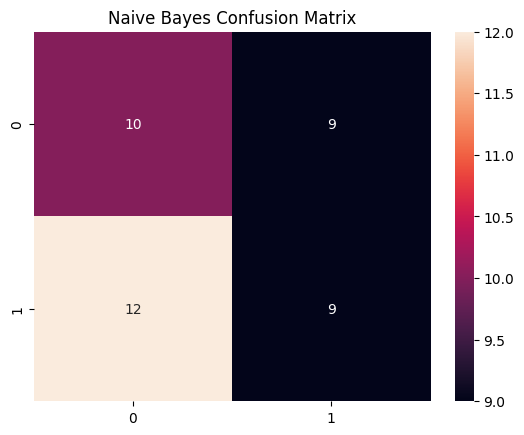

In [8]:

from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d')
plt.title("Naive Bayes Confusion Matrix")
plt.show()


### 📌 K-Nearest Neighbors Classifier

Best K: {'n_neighbors': 3}
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.65      0.52      0.58        21

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



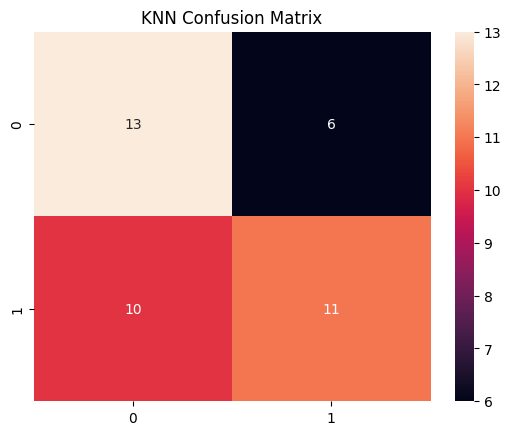

In [9]:

from sklearn.neighbors import KNeighborsClassifier

# 🛠️ Hyperparameter Tuning
params = {'n_neighbors': list(range(3, 20))}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5)
grid_knn.fit(X_train, y_train)

knn_best = grid_knn.best_estimator_
y_pred_knn = knn_best.predict(X_test)

print("Best K:", grid_knn.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d')
plt.title("KNN Confusion Matrix")
plt.show()


### 📌 Decision Tree Classifier

Best Params: {'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.525
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.79      0.61        19
           1       0.60      0.29      0.39        21

    accuracy                           0.53        40
   macro avg       0.55      0.54      0.50        40
weighted avg       0.55      0.53      0.49        40



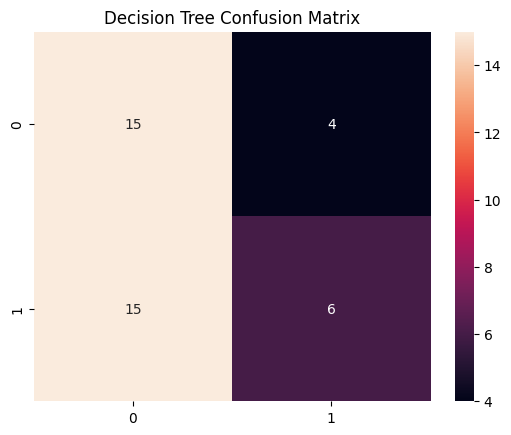

In [10]:

from sklearn.tree import DecisionTreeClassifier

# 🛠️ Hyperparameter Tuning
params = {'max_depth': [3, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=5)
grid_dt.fit(X_train, y_train)

dt_best = grid_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test)

print("Best Params:", grid_dt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()


## 📊 Phase 3: Model Comparison and Insights

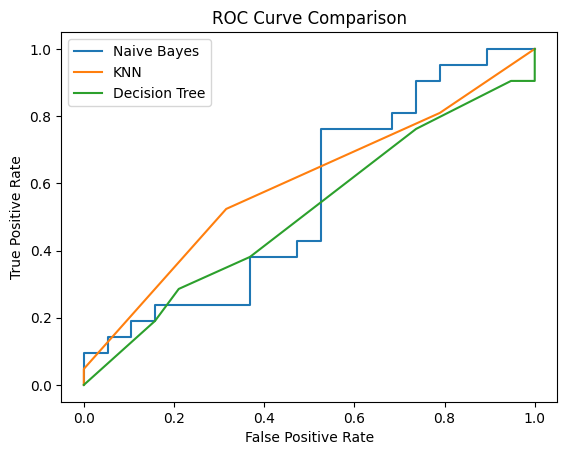

In [11]:

# 🔁 ROC Curve Comparison
y_pred_nb_proba = nb_model.predict_proba(X_test)[:,1]
y_pred_knn_proba = knn_best.predict_proba(X_test)[:,1]
y_pred_dt_proba = dt_best.predict_proba(X_test)[:,1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)

plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()



### ✅ Summary and Recommendation

- **Naive Bayes** performed well on continuous features but may be less interpretable.
- **KNN** provided good results after tuning the best `K` value.
- **Decision Tree** offered a balance of performance and interpretability.

🔍 **Best Model Recommendation**: Use **Decision Tree** if interpretability is important, otherwise **KNN** can provide slightly better performance after tuning.
